## Libraries

In [1]:
%%time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
#import tensorflow.keras.utils.to_categorical
import numpy as np
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras import optimizers
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
%matplotlib inline
import keras
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.layers import LeakyReLU
from emnist import extract_training_samples
from emnist import extract_test_samples
from tensorflow.keras import utils
from matplotlib import pyplot
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pandas as pd
import time
import os
from numpy import mean
from numpy import std
from matplotlib import pyplot
from sklearn.model_selection import KFold
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.


CPU times: user 2.46 s, sys: 1.44 s, total: 3.9 s
Wall time: 45.2 s


## Data Preparations, global parameters and optimisation tunings

In [2]:
#Global para's

img_width, img_height = 28, 28
leaky_relu_alpha = 0.1

In [3]:
X_train, y_train = extract_training_samples('balanced')
X_test, y_test = extract_test_samples('balanced')

num_pixels = X_train.shape[1] * X_train.shape[2]
X_train = X_train.reshape((X_train.shape[0], num_pixels)).astype('float32')
X_test = X_test.reshape((X_test.shape[0], num_pixels)).astype('float32')

X_train = X_train / 255
X_test = X_test / 255

y_train = utils.to_categorical(y_train)
y_test = utils.to_categorical(y_test)
num_classes = y_test.shape[1]


'''
CNN's require a different formal of input data as compared to MLP;
this function reshapes the image data accordingly.

Reshapring for 3D cnn format since we are using black and white images, gotta made it 3dim.

'''

img_width, img_height = 28, 28

X_trainCNN, y_trainCNN = extract_training_samples('balanced')
X_testCNN, y_testCNN = extract_test_samples('balanced')

if K.image_data_format() == 'channels_first':
    X_trainCNN = X_trainCNN.reshape(X_trainCNN.shape[0], 1, img_width, img_height)
    X_testCNN = X_testCNN.reshape(X_testCNN.shape[0], 1, img_width, img_height)
    CNNinput_shape = (1, img_width, img_height)
else:
    X_trainCNN = X_trainCNN.reshape(X_trainCNN.shape[0], img_width, img_height, 1)
    X_testCNN = X_testCNN.reshape(X_testCNN.shape[0], img_width, img_height, 1)
    CNNinput_shape = (img_width, img_height, 1)
    
X_trainCNN = X_trainCNN / 255
X_testCNN = X_testCNN / 255
    
y_trainCNN = utils.to_categorical(y_trainCNN)
y_testCNN = utils.to_categorical(y_testCNN)

### Image Augmentation

In [4]:
'''
Image rotation of 40 degree's (minics difference angles of writing)
Shear, Vertical, Horizontal shifts by 0.08 (minic displacements and cursive fonts)
Zoom's in by 0.08 (minics alphabets size difference)

'''

img_gen = ImageDataGenerator(
    featurewise_center=False,  
    samplewise_center=False,  
    featurewise_std_normalization=False,  
    samplewise_std_normalization=False,  
    zca_whitening=False,  
    rotation_range=40,
    #shear_range = 30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    #zoom_range = [-0.5,0.5],
    horizontal_flip=False)

In [5]:
'''
An example of how the image augmentation function can affect our data.
'''

def gallery(array, ncols=3):
    nindex, height, width = array.shape
    nrows = nindex//ncols
    assert nindex == nrows*ncols
    # want result.shape = (height*nrows, width*ncols)
    result = (array.reshape(nrows, ncols, height, width)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncols))
    return result


distorted = np.empty(shape = (0,28,28), dtype = "uint8")
i = 0
for batch in img_gen.flow(X_trainCNN[[4]]*255, batch_size=1,):
    i += 1
    pd
    distorted = np.append(distorted, batch.reshape((28,28)).astype("uint8"))
    if i > 20:
        break
distorted = distorted.reshape((21,28,28))



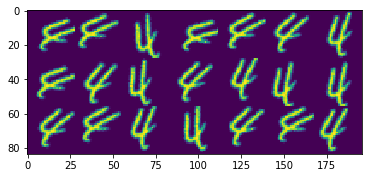

In [6]:
plt.imshow(gallery(distorted, ncols = 7))


## Baseline models for NN
- Baseline MLP (Simple one Hidden layer network)
- Baseline CNN (Simple one CNN layer)

In [7]:
def baseline_model():
     
    model = Sequential()
    
    model.add(Dense(num_pixels, input_dim=num_pixels, kernel_initializer='normal', activation='relu'))
    
    model.add(Dense(num_classes, kernel_initializer='normal', activation='softmax'))
    
    #adam = optimizers.Adam(lr = 0.001)
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model

base_model = baseline_model()
base_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 784)               615440    
_________________________________________________________________
dense_1 (Dense)              (None, 47)                36895     
Total params: 652,335
Trainable params: 652,335
Non-trainable params: 0
_________________________________________________________________


In [8]:
%%time

#Non augmented Train

baseMLPHistory = base_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=200, verbose=2)
base_scores = base_model.evaluate(X_test, y_test, verbose=0)
print("Baseline Error: %.2f%%" % (100-base_scores[1]*100))
print(f'Test loss for base MLP: {base_scores[0]} / Test accuracy: {base_scores[1]}')


Epoch 1/30
564/564 - 2s - loss: 1.5989 - accuracy: 0.5822 - val_loss: 1.1806 - val_accuracy: 0.6704
Epoch 2/30
564/564 - 2s - loss: 1.0461 - accuracy: 0.7071 - val_loss: 0.9843 - val_accuracy: 0.7233
Epoch 3/30
564/564 - 2s - loss: 0.8891 - accuracy: 0.7465 - val_loss: 0.8697 - val_accuracy: 0.7528
Epoch 4/30
564/564 - 2s - loss: 0.7819 - accuracy: 0.7740 - val_loss: 0.7882 - val_accuracy: 0.7706
Epoch 5/30
564/564 - 2s - loss: 0.7053 - accuracy: 0.7928 - val_loss: 0.7255 - val_accuracy: 0.7866
Epoch 6/30
564/564 - 2s - loss: 0.6501 - accuracy: 0.8065 - val_loss: 0.6813 - val_accuracy: 0.7986
Epoch 7/30
564/564 - 2s - loss: 0.6052 - accuracy: 0.8181 - val_loss: 0.6477 - val_accuracy: 0.8059
Epoch 8/30
564/564 - 2s - loss: 0.5708 - accuracy: 0.8255 - val_loss: 0.6198 - val_accuracy: 0.8162
Epoch 9/30
564/564 - 2s - loss: 0.5420 - accuracy: 0.8333 - val_loss: 0.6025 - val_accuracy: 0.8154
Epoch 10/30
564/564 - 2s - loss: 0.5183 - accuracy: 0.8395 - val_loss: 0.5823 - val_accuracy: 0.8213

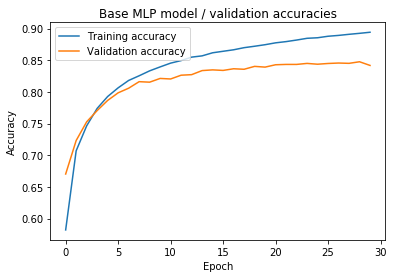

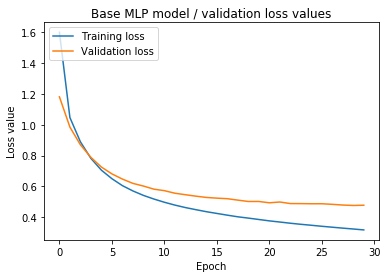

In [9]:
plt.plot(baseMLPHistory.history['accuracy'], label='Training accuracy')
plt.plot(baseMLPHistory.history['val_accuracy'], label='Validation accuracy')
plt.title('Base MLP model / validation accuracies')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

plt.plot(baseMLPHistory.history['loss'], label='Training loss')
plt.plot(baseMLPHistory.history['val_loss'], label='Validation loss')
plt.title('Base MLP model / validation loss values')
plt.ylabel('Loss value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()


In [10]:
def base_CNN():
    model = Sequential()
    
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=CNNinput_shape))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(num_classes, activation='softmax'))
    
    # compile model
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model

In [11]:
base_CNN_model = base_CNN()
base_CNN_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               802944    
_________________________________________________________________
dense_3 (Dense)              (None, 47)                6063      
Total params: 818,575
Trainable params: 818,575
Non-trainable params: 0
________________________________________________

In [12]:
%%time
baseCNNHistory = base_CNN_model.fit(X_trainCNN, y_trainCNN, validation_data=(X_testCNN, y_testCNN), epochs=30, batch_size=200, verbose=2)
base_CNN_scores = base_CNN_model.evaluate(X_testCNN, y_testCNN, verbose=0)

print("Baseline Error: %.2f%%" % (100-base_CNN_scores[1]*100))
print(f'Test loss for base CNN: {base_CNN_scores[0]} / Test accuracy: {base_CNN_scores[1]}')

Epoch 1/30
564/564 - 30s - loss: 0.9531 - accuracy: 0.7188 - val_loss: 0.5641 - val_accuracy: 0.8190
Epoch 2/30
564/564 - 29s - loss: 0.4772 - accuracy: 0.8411 - val_loss: 0.4792 - val_accuracy: 0.8433
Epoch 3/30
564/564 - 29s - loss: 0.4074 - accuracy: 0.8608 - val_loss: 0.4627 - val_accuracy: 0.8480
Epoch 4/30
564/564 - 29s - loss: 0.3664 - accuracy: 0.8728 - val_loss: 0.4352 - val_accuracy: 0.8539
Epoch 5/30
564/564 - 29s - loss: 0.3369 - accuracy: 0.8809 - val_loss: 0.4280 - val_accuracy: 0.8599
Epoch 6/30
564/564 - 29s - loss: 0.3125 - accuracy: 0.8877 - val_loss: 0.4089 - val_accuracy: 0.8617
Epoch 7/30
564/564 - 29s - loss: 0.2925 - accuracy: 0.8923 - val_loss: 0.4048 - val_accuracy: 0.8641
Epoch 8/30
564/564 - 28s - loss: 0.2759 - accuracy: 0.8985 - val_loss: 0.4125 - val_accuracy: 0.8633
Epoch 9/30
564/564 - 29s - loss: 0.2605 - accuracy: 0.9033 - val_loss: 0.4210 - val_accuracy: 0.8580
Epoch 10/30
564/564 - 28s - loss: 0.2469 - accuracy: 0.9068 - val_loss: 0.4071 - val_accura

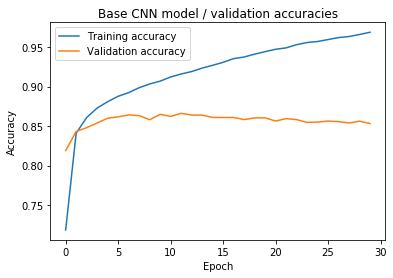

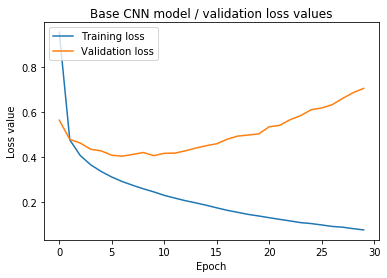

In [13]:
plt.plot(baseCNNHistory.history['accuracy'], label='Training accuracy')
plt.plot(baseCNNHistory.history['val_accuracy'], label='Validation accuracy')
plt.title('Base CNN model / validation accuracies')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

plt.plot(baseCNNHistory.history['loss'], label='Training loss')
plt.plot(baseCNNHistory.history['val_loss'], label='Validation loss')
plt.title('Base CNN model / validation loss values')
plt.ylabel('Loss value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

In [ ]:

def conv_model():

    '''
    {784 - [32C3-32C3-32C5S2] - [64C3-64C3-64C5S2] - 128 - 47}
    '''
    
    model = Sequential()
    
    model.add(Conv2D(32, kernel_size = 3,input_shape = CNNinput_shape))
    model.add(LeakyReLU(alpha=leaky_relu_alpha))
    model.add(BatchNormalization())
    
    model.add(Conv2D(32, kernel_size = 3))
    model.add(LeakyReLU(alpha=leaky_relu_alpha))    
    model.add(BatchNormalization())

    model.add(Conv2D(32, kernel_size = 5, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=leaky_relu_alpha))    
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    
    
    model.add(Conv2D(64, kernel_size = 3))
    model.add(LeakyReLU(alpha=leaky_relu_alpha))
    model.add(BatchNormalization())
    
    model.add(Conv2D(64, kernel_size = 3))
    model.add(LeakyReLU(alpha=leaky_relu_alpha))
    model.add(BatchNormalization())
        
    model.add(Conv2D(64, kernel_size = 5, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=leaky_relu_alpha))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    

    model.add(Conv2D(128, kernel_size = 4))
    model.add(LeakyReLU(alpha=leaky_relu_alpha))
    model.add(BatchNormalization())
    
    model.add(Flatten())
    model.add(Dropout(0.5))
               
    model.add(Dense(num_classes, activation='softmax'))
    
    adam = optimizers.Adam(lr = 0.001)
    model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return model

In [ ]:
CNN2_model = conv_model()
CNN2_model.summary()

In [ ]:
from keras_sequential_ascii import keras2ascii
keras2ascii(CNN2_model)


In [ ]:

%%time
# No augmented Data

CNN2History = CNN2_model.fit(X_trainCNN, y_trainCNN, validation_data=(X_testCNN, y_testCNN), epochs=75, batch_size=100, verbose=2)
CNN2_scores = CNN2_model.evaluate(X_testCNN, y_testCNN, verbose=0)

print("Baseline Error: %.2f%%" % (100-CNN2_scores[1]*100))
print(f'Test loss for base CNN: {CNN2_scores[0]} / Test accuracy: {CNN2_scores[1]}')

In [ ]:
plt.plot(CNN2History.history['accuracy'], label='Training accuracy')
plt.plot(CNN2History.history['val_accuracy'], label='Validation accuracy')
plt.title('CNN2 model / validation accuracies')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

plt.plot(CNN2History.history['loss'], label='Training loss')
plt.plot(CNN2History.history['val_loss'], label='Validation loss')
plt.title('CNN2 model / validation loss values')
plt.ylabel('Loss value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

In [ ]:
'''model_json = CNN2_model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
CNN2_model.save_weights("model.h5")
print("Saved model to disk")'''

## Optimisation (Hyperparameters & Learning rates)

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

In [ ]:
optmodel = KerasClassifier(build_fn= conv_model, verbose = 0)

In [ ]:
batch_size = [50,100,150,200]
init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
learn_rate = [0.001, 0.01, 0.1,0.2]
dropout_rate = [0.2,0.3,0.4,0.5]

In [ ]:
param_dist = dict(batch_size=batch_size)

In [ ]:
#grid = GridSearchCV(estimator=optmodel, param_grid=param_grid, cv=2)

In [ ]:
random_search = RandomizedSearchCV(estimator=optmodel, param_distributions=param_dist, verbose = 2, cv = 3)


In [ ]:
%%time
RS_S = random_search.fit(X_trainCNN, y_trainCNN, epochs=10)

In [ ]:
print("Best: %f using %s" % (RS_S.best_score_, RS_S.best_params_))
means = RS_S.cv_results_['mean_test_score']
stds = RS_S.cv_results_['std_test_score']
params = RS_S.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Things to tune;

- Batch size [50,100,150,200]

- epochs (plus early stopping) [20,30,40,50] [later]
- optimisation learning rate [0.001, 0.01, 0.1,0.2]
- activation functions (maybe)
- weight initialisation ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
- drop out [0.2,0.3,0.4,0.5]


In [ ]:
dropout_rate = 0.4
learningrate = 0.001
init_mode = 'he_uniform'

In [ ]:
def conv_modelOPT():

    '''
    {784 - [32C3-32C3-32C5S2] - [64C3-64C3-64C5S2] - 128 - 47}
    '''
    
    model = Sequential()
    
    model.add(Conv2D(32, kernel_size = 3, input_shape = CNNinput_shape))
    model.add(LeakyReLU(alpha=leaky_relu_alpha))
    model.add(BatchNormalization())
    
    model.add(Conv2D(32, kernel_size = 3))
    model.add(LeakyReLU(alpha=leaky_relu_alpha))    
    model.add(BatchNormalization())

    model.add(Conv2D(32, kernel_size = 5, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=leaky_relu_alpha))    
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    
    
    model.add(Conv2D(64, kernel_size = 3))
    model.add(LeakyReLU(alpha=leaky_relu_alpha))
    model.add(BatchNormalization())
    
    model.add(Conv2D(64, kernel_size = 3))
    model.add(LeakyReLU(alpha=leaky_relu_alpha))
    model.add(BatchNormalization())
        
    model.add(Conv2D(64, kernel_size = 5, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=leaky_relu_alpha))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    
    

    model.add(Conv2D(128, kernel_size = 4))
    model.add(LeakyReLU(alpha=leaky_relu_alpha))
    model.add(BatchNormalization())
    
    model.add(Flatten())
    model.add(Dropout(0.4))
               
    model.add(Dense(num_classes, activation='softmax'))
    
    adam = optimizers.Adam(lr =  0.001)
    model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return model

In [ ]:
optmodel = KerasClassifier(build_fn= conv_modelOPT, verbose = 1)
batch_size = [50,100,150,200]
param_dist = dict(batch_size=batch_size)
random_search = RandomizedSearchCV(estimator=optmodel, param_distributions=param_dist, verbose = 2, cv = 3)


In [ ]:
print("Best: %f using %s" % (RS_S1.best_score_, RS_S1.best_params_))
means = RS_S1.cv_results_['mean_test_score']
stds = RS_S1.cv_results_['std_test_score']
params = RS_S1.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
dropout_rate = [0.0, 0.1, 0.2]

In [ ]:
def conv_modelOPT2(dropout_rate=0.0):

    '''
    {784 - [32C3-32C3-32C5S2] - [64C3-64C3-64C5S2] - 128 - 47}
    '''
    
    model = Sequential(dropout_rate = 0.0)
    
    model.add(Conv2D(32, kernel_size = 3, input_shape = CNNinput_shape))
    model.add(LeakyReLU(alpha=leaky_relu_alpha))
    model.add(BatchNormalization())
    
    model.add(Conv2D(32, kernel_size = 3))
    model.add(LeakyReLU(alpha=leaky_relu_alpha))    
    model.add(BatchNormalization())

    model.add(Conv2D(32, kernel_size = 5, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=leaky_relu_alpha))    
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    
    
    model.add(Conv2D(64, kernel_size = 3))
    model.add(LeakyReLU(alpha=leaky_relu_alpha))
    model.add(BatchNormalization())
    
    model.add(Conv2D(64, kernel_size = 3))
    model.add(LeakyReLU(alpha=leaky_relu_alpha))
    model.add(BatchNormalization())
        
    model.add(Conv2D(64, kernel_size = 5, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=leaky_relu_alpha))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    

    model.add(Conv2D(128, kernel_size = 4))
    model.add(LeakyReLU(alpha=leaky_relu_alpha))
    model.add(BatchNormalization())
    
    model.add(Flatten())
    model.add(Dropout(dropout_rate))
               
    model.add(Dense(num_classes, activation='softmax'))
    
    adam = optimizers.Adam(lr =  0.001)
    model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return model

In [ ]:
optmodel2 = KerasClassifier(build_fn= conv_modelOPT2, verbose = 1)
dropout = [0.0, 0.1, 0.2]
param_dist2 = dict(dropout_rate = dropout)
random_search2 = RandomizedSearchCV(estimator=optmodel2, param_distributions=param_dist2,verbose = 2, cv = 3)


In [ ]:
%%time

model = KerasClassifier(build_fn=conv_modelOPT2,  verbose=2)
dropout_rate = [0.0, 0.1, 0.2]
param = dict(dropout_rate=dropout_rate)

random = RandomizedSearchCV(estimator=model, param_distributions=param,verbose = 2, cv=3)

In [ ]:
%%time

random_result = random.fit(X_trainCNN, y_trainCNN,verbose = 2, epochs=20, batch_size=150)



In [ ]:
optmodel = KerasClassifier(build_fn= conv_modelOPT, verbose = 1)
batch_size = [50,100,150,200]
param_dist = dict(batch_size=batch_size)
random_search = RandomizedSearchCV(estimator=optmodel, param_distributions=param_dist, verbose = 2, cv = 3)


In [ ]:
%%time

RS_S2 = random_search2.fit(X_trainCNN, y_trainCNN,verbose = 2, batch_size = 150, epochs=20)

In [ ]:
batch_size = [50,100,150,200]
#init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
learn_rate = [0.001, 0.01, 0.1,0.2]
#dropout_rate = [0.2,0.3,0.4,0.5]
#weight_constraint = [1,2,3,4,5]

In [ ]:
param_dist = dict(batch_size=batch_size)

#, dropout_rate =dropout_rate, , learn_rate = learn_rate
#                  weight_constraint=weight_constraint

In [ ]:
optmodel = KerasClassifier(build_fn=conv_modelOPT, verbose = 2)

In [ ]:
random_search = RandomizedSearchCV(estimator=optmodel, param_distributions=param_dist, verbose = 2, cv = 3, n_jobs= 24)
